<a href="https://colab.research.google.com/github/pinellolab/DNA-Diffusion/blob/classifier-free-diff/notebooks/Classifier_Free_Enhancer_UNET_bitdiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DNA difussion
- 4,200 inputs
- ~~Current dataset are less than 1k enhancers from the cell k562~~
-  Curated dataset of 160,000 sequences, 10k per DHS NMF component, selected in such a way that each sequence is highly concentrated in a single component:

- UNET needs to be optimized to rectangular shape . It's currently accepting rectangular shapes (4,200) , but it can be probably improved for our model.(less memory and better performance). We need to check on the literature examples of SOTA sequence arquitectures. We may need a hybrid.
- This nootebook doens't have conditional inputs implemented(cell type, signal strenght , motifs)  
  - How to add this on the UNET? concact Embeddings on the UNET  blocks.
  - https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py  
- Change the bit diffusion sampling process  to expect conditional information 
  - Should be a simple task.(Adding the information on the model)
-How stable diffusion allows different levels of conditional "guidance"(how much the generation should care abount the text?). Are they adding factor to regulate the mask intensity?    

In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -Uqq ipdb
import ipdb


     |████████████████████████████████| 793 kB 37.8 MB/s 
     |████████████████████████████████| 1.6 MB 45.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


# UTILS

In [3]:
import numpy as np


def one_hot_encode(seq, alphabet, max_seq_len):
    """One-hot encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros((max_seq_len, len(alphabet)))
    for i in range(seq_len):
        seq_array[i, alphabet.index(seq[i])] = 1
    return seq_array

In [4]:
def encode(seq, alphabet):
    """Encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros(len(alphabet))
    for i in range(seq_len):
        seq_array[alphabet.index(seq[i])] = 1
    
    return seq_array

In [5]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import seaborn as sns
import torchvision.transforms as T
import numpy as np
from tqdm import tqdm_notebook

import math
from pathlib import Path
from random import random
from functools import partial
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
from torch.special import expm1
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from torch.optim import Adam, SGD
from torchvision import transforms as T, utils

from PIL import Image
from tqdm.auto import tqdm

import torch
from torch.optim import Adam
from torch.cuda.amp import GradScaler, autocast


import matplotlib.pyplot as plt

import seaborn as sns

import gc

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv("drive/MyDrive/train_all_classifier_WM20220916.csv", sep="\t")
df.head()

,Unnamed: 0,seqname,start,end,DHS_width,summit,total_signal,numsamples,numpeaks,C1,...,C10,C11,C12,C13,C14,C15,C16,raw_sequence,component,proportion
0,1241720,chr16,68843660,68843880,220,68843790,122.770678,61,61,0.101076,...,0.005301,0.016703,0.000000,0.000000,0.000000,0.000000,0.0,GAGGCATTGAAGCTGCTGCTGAGCCCGGGAGGTGAGAGGACGCATC...,0,0.767372
1,2251755,chr3,143634500,143634720,220,143634610,0.780678,1,1,0.000000,...,0.000000,0.000000,0.000000,0.008636,0.000000,0.000000,0.0,CTCTCCAACTTTTTCCCTGAGTATTGCCAGCACACTTTTAATCTCC...,12,0.869445
2,3136863,chr7,156928220,156928441,221,156928330,145.069295,32,32,0.000000,...,0.046526,0.002177,0.008559,0.000000,0.106442,0.000000,0.0,CTTCCTGATAAGATCTCAGGAGCTGGGCAAGTGGCTCAAGTATGTG...,13,0.585111
3,2234828,chr3,130738277,130738580,303,130738460,13.140313,10,10,0.000531,...,0.000000,0.000000,0.000000,0.000370,0.000000,0.043161,0.0,TGAGGAACATAAGCACATAAAATATAATCTAGAAGTTGGTGCTGAG...,14,0.961271
4,3060272,chr7,95784860,95785160,300,95785010,17.523798,7,7,0.000000,...,0.011486,0.000000,0.000000,0.000000,0.036866,0.000000,0.0,CCAGGTTCTGCCATTCACTTGGGGCCAGCATAAACAAGGGGGCAGG...,13,0.762448


Motifs were generated only looking at sequences with component == 0
We will only trian on 10k sequences

In [8]:
len(df)

160000

In [9]:
# 16 NMF cell types
df.component.nunique()

16

In [10]:
cell_types = sorted(list(df.component.unique()))

In [11]:
cell_types

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [12]:
# motifs = sorted(open("drive/MyDrive/unique_motifs.txt").read().splitlines())
# motifs[:5]

#Processing samples to train

In [13]:
dna_alphabet = ['A', 'C', 'T', 'G']
x_train_seq = np.array([one_hot_encode(x, dna_alphabet, 200) for x in tqdm_notebook(df['raw_sequence']) if 'N' not in x ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/160000 [00:00<?, ?it/s]

In [14]:
#x_train_motif = np.array([encode(sorted(eval(x)), motifs) for x in tqdm_notebook(df['motifs'])])

In [15]:
x_train_cell_type = F.one_hot(torch.from_numpy(df["component"].to_numpy()), len(cell_types))

In [16]:
x_train_seq.shape, x_train_cell_type.shape

((160000, 200, 4), torch.Size([160000, 16]))

In [17]:
nucleotides = ['A', 'C', 'T', 'G']


def show_seq(dataloader_seq):
    for i_image in dataloader_seq:
      for image in i_image:
        image = image.numpy().reshape(4,100)
        print (image)
        plt.rcParams["figure.figsize"] = (20,1)
        pd_seq = pd.DataFrame(image)
        pd_seq.index = nucleotides
        sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0) 
        plt.show()

class SequenceDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, seqs, c, transform=None):
      'Initialization'
      self.seqs = seqs
      self.c = c
      self.transform = transform

    def __len__(self):
      'Denotes the total number of samples'
      return len(self.seqs)

    def __getitem__(self, index):
      'Generates one sample of data'
      # Select sample
      image = self.seqs[index]

      x = self.transform(image)

      y = self.c[index]
      
      return x, y
  

 

In [18]:
tf = T.Compose([T.ToTensor()])
batch_size = 64
seq_dataset = SequenceDataset(seqs=x_train_seq, c=x_train_cell_type, transform=tf)
train_dl = DataLoader(seq_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [19]:
for (x, y) in train_dl:
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 1, 200, 4])
torch.Size([64, 16])


### Train data examples

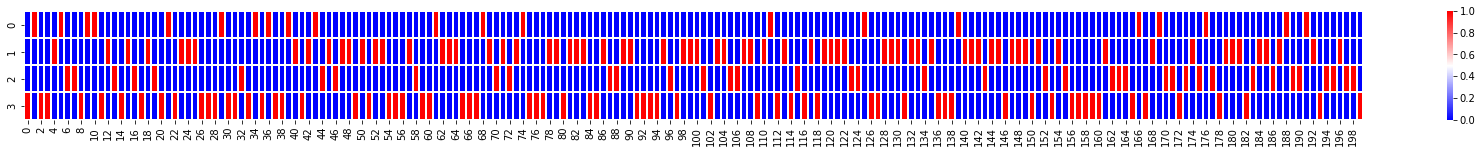

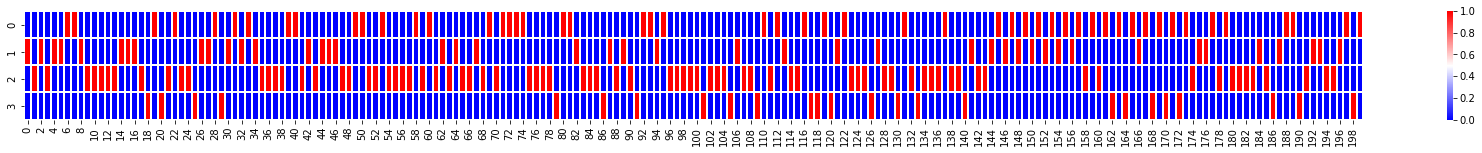

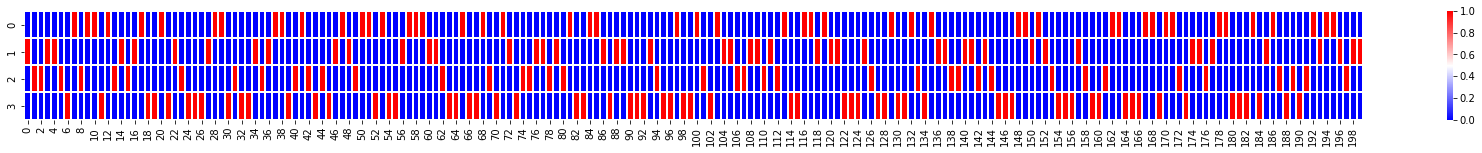

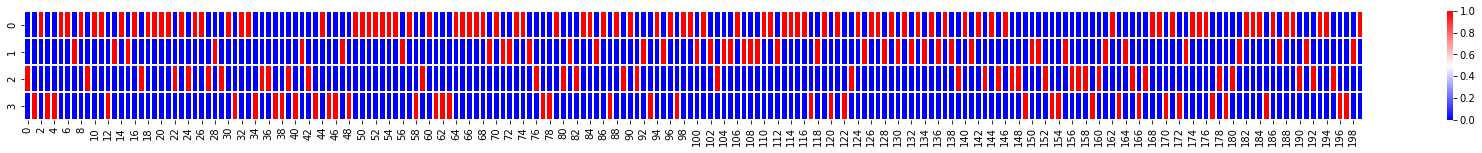

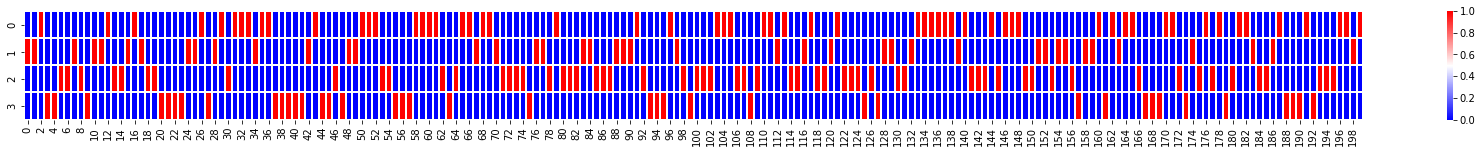

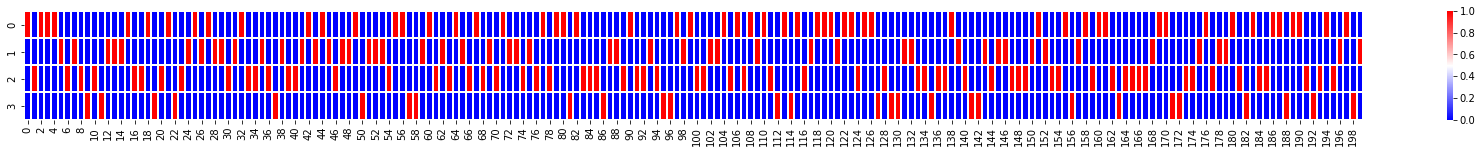

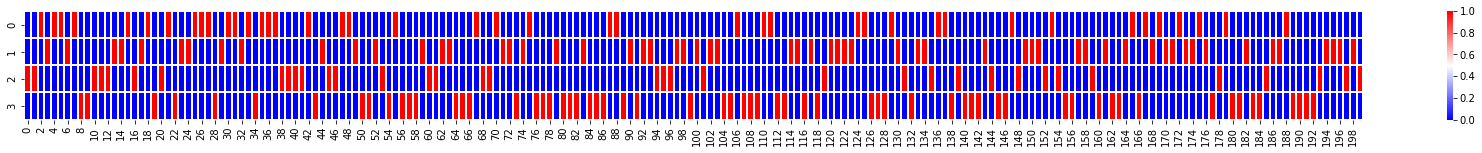

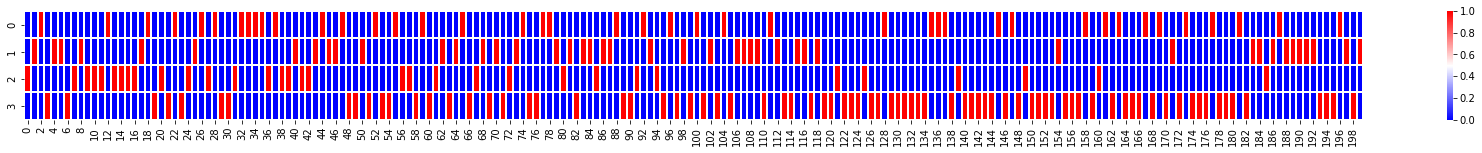

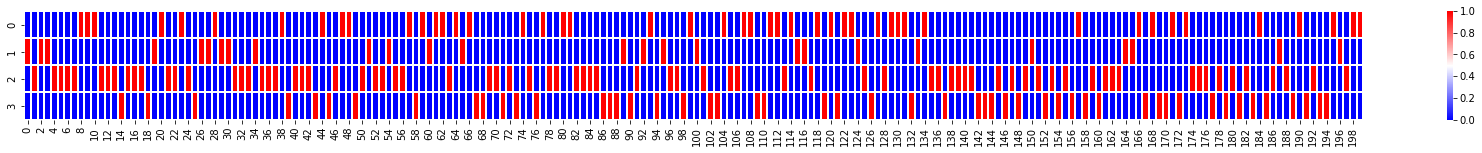

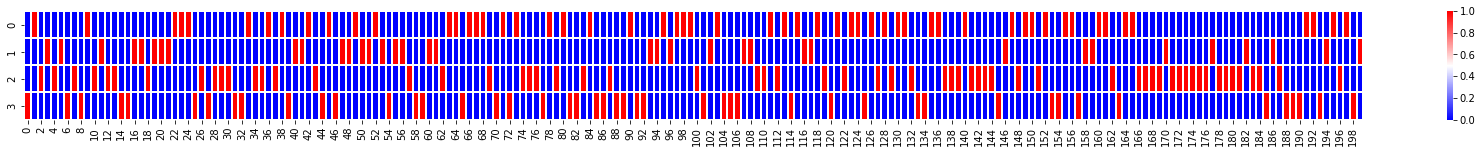

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

for x in x_train_seq[:10]:
  df = pd.DataFrame(x.T)
  plt.rcParams["figure.figsize"] = (30,2)
  sns.heatmap(df, cmap='bwr', linewidths=1)
  plt.show()

# Modified bit difussion code

Model was generating squared noise and expecting squared images.  
I adjusted it to expect the shape 4,200  

In [21]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [22]:
BITS = 1  # the bit representation is perfect after this transformation


def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

def l2norm(t):
    return F.normalize(t, dim = -1)

# small helper modules


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d



class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# positional embeds

class LearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with learned sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = EmbedFC(time_emb_dim, dim_out * 2)

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class ResnetBlockClassConditioned(ResnetBlock):
    def __init__(self, dim, dim_out, *, num_classes, class_embed_dim, time_emb_dim = None, groups = 8):
        super().__init__(dim=dim+class_embed_dim, dim_out=dim_out, time_emb_dim=time_emb_dim, groups=groups)
        self.class_mlp = EmbedFC(num_classes, class_embed_dim)
      

  
    def forward(self, x, time_emb=None, c=None, mask=None):
        emb_c = self.class_mlp(c)
        emb_c = emb_c.view(*emb_c.shape, 1, 1)
        emb_c = emb_c.expand(-1, -1, x.shape[-2], x.shape[-1])

        if mask:
          # mask classes so we can jointly train condtioned and unconditioned
          # masking with 1e-9 like we do in Transformers
          emb_c = emb_c.masked_fill(mask, 1e-9)

        x = torch.cat([x, emb_c], axis=1)

        return super().forward(x, time_emb)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32, scale = 10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

# model

def decimal_to_bits(x, bits = BITS):
    """ expects image tensor ranging from 0 to 1, outputs bit tensor ranging from -1 to 1 """
    device = x.device

    x = (x * 1).int().clamp(0, 1)  #x = (x * 255).int().clamp(0, 255)

    mask = 2 ** torch.arange(bits - 1, -1, -1, device = device)
    mask = rearrange(mask, 'd -> d 1 1')
    x = rearrange(x, 'b c h w -> b c 1 h w')

    bits = ((x & mask) != 0).float()
    bits = rearrange(bits, 'b c d h w -> b (c d) h w')
    bits = bits * 2 - 1
    return bits

def bits_to_decimal(x, bits = BITS):
    """ expects bits from -1 to 1, outputs image tensor from 0 to 1 """
    device = x.device

    x = (x > 0).int()
    mask = 2 ** torch.arange(bits - 1, -1, -1, device = device, dtype = torch.int32)

    mask = rearrange(mask, 'd -> d 1 1')
    #x = rearrange(x, 'b (c d) h w -> b c d h w', d = 8)
    x = rearrange(x, 'b (c d) h w -> b c d h w', d = 1) #lucas

    dec = reduce(x * mask, 'b c d h w -> b c h w', 'sum')
    return (dec / 1).clamp(0., 1.)   # changed(dec / 255).clamp(0., 1.)

# bit diffusion class

def log(t, eps = 1e-20):
    return torch.log(t.clamp(min = eps))

def right_pad_dims_to(x, t):
    padding_dims = x.ndim - t.ndim
    if padding_dims <= 0:
        return t
    return t.view(*t.shape, *((1,) * padding_dims))

def beta_linear_log_snr(t):
    return -torch.log(expm1(1e-4 + 10 * (t ** 2)))

def alpha_cosine_log_snr(t, s: float = 0.008):
    return -log((torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** -2) - 1, eps = 1e-5) # not sure if this accounts for beta being clipped to 0.999 in discrete version

def log_snr_to_alpha_sigma(log_snr):
    return torch.sqrt(torch.sigmoid(log_snr)), torch.sqrt(torch.sigmoid(-log_snr))







#UNET (current input is [4,200])

In [64]:
# each layer has a time embedding AND class conditioned embedding

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        bits = BITS,
        resnet_block_groups = 8,
        learned_sinusoidal_dim = 16,
        num_classes=10,
        class_embed_dim=3,
    ):
        super().__init__()

        # determine dimensions

        channels *= bits
        self.channels = channels
        self.num_classes = num_classes

        input_channels = channels * 2

        init_dim = default(init_dim, dim)
        #self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3) # original TODO for zach: is there a difference?
        self.init_conv = nn.Conv2d(input_channels, init_dim, (7,7), padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]


        in_out = list(zip(dims[:-1], dims[1:]))
        block_klass = partial(ResnetBlockClassConditioned, groups=resnet_block_groups,
                              num_classes=num_classes, class_embed_dim=class_embed_dim)

        # time embeddings

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )
        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)

        self.final_conv = nn.Conv2d(dim, 1, 1)


    def forward(self, x, time, c, x_self_cond=None, context_mask=None):
        x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
        x = torch.cat((x_self_cond, x), dim=1)
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)
        if context_mask is not None:
          context_mask = context_mask.repeat(1, self.num_classes)
          
        h = []
        for i, (block1, block2, attn, downsample) in enumerate(self.downs):
            x = block1(x, t, c)
            h.append(x)

            x = block2(x, t, c)

            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t, c)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, c)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t, c)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t, c)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t, c)
        
        x = self.final_conv(x)
        return x

In [75]:
class BitDiffusion(nn.Module):
    def __init__(
        self,
        model,
        *,
        image_size,
        timesteps = 1000,
        use_ddim = False,
        noise_schedule = 'cosine',
        time_difference = 0.,
        bit_scale = 1.,
        # prob we train an unconditionally
        p_uncond = 0.1
    ):
        super().__init__()
        self.model = model
        self.channels = self.model.channels

        self.image_size = image_size

        if noise_schedule == "linear":
            self.log_snr = beta_linear_log_snr
        elif noise_schedule == "cosine":
            self.log_snr = alpha_cosine_log_snr
        else:
            raise ValueError(f'invalid noise schedule {noise_schedule}')

        self.bit_scale = bit_scale

        self.timesteps = timesteps
        self.use_ddim = use_ddim

        # proposed in the paper, summed to time_next
        # as a way to fix a deficiency in self-conditioning and lower FID when the number of sampling timesteps is < 400

        self.time_difference = time_difference
        self.p_uncond = p_uncond

    @property
    def device(self):
        return next(self.model.parameters()).device

    def get_sampling_timesteps(self, batch, *, device):
        times = torch.linspace(1., 0., self.timesteps + 1, device = device)
        times = repeat(times, 't -> b t', b = batch)
        times = torch.stack((times[:, :-1], times[:, 1:]), dim = 0)
        times = times.unbind(dim = -1)
        return times

    @torch.no_grad()
    def ddpm_sample(self, shape, time_difference=None, classes=None):
        batch, device = shape[0], self.device

        time_difference = default(time_difference, self.time_difference)

        time_pairs = self.get_sampling_timesteps(batch, device = device)

        img = torch.randn(shape, device=device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step', total = self.timesteps):

            # add the time delay

            time_next = (time_next - self.time_difference).clamp(min = 0.)

            noise_cond = self.log_snr(time)

            # get predicted x0

            x_start = self.model(img, noise_cond, classes, x_start)

            # clip x0

            x_start.clamp_(-self.bit_scale, self.bit_scale)

            # get log(snr)

            log_snr = self.log_snr(time)
            log_snr_next = self.log_snr(time_next)
            log_snr, log_snr_next = map(partial(right_pad_dims_to, img), (log_snr, log_snr_next))

            # get alpha sigma of time and next time

            alpha, sigma = log_snr_to_alpha_sigma(log_snr)
            alpha_next, sigma_next = log_snr_to_alpha_sigma(log_snr_next)

            # derive posterior mean and variance

            c = -expm1(log_snr - log_snr_next)

            mean = alpha_next * (img * (1 - c) / alpha + c * x_start)
            variance = (sigma_next ** 2) * c
            log_variance = log(variance)

            # get noise

            noise = torch.where(
                rearrange(time_next > 0, 'b -> b 1 1 1'),
                torch.randn_like(img),
                torch.zeros_like(img)
            )

            img = mean + (0.5 * log_variance).exp() * noise

        return bits_to_decimal(img)

    @torch.no_grad()
    def ddim_sample(self, shape, classes, time_difference = None):
        batch, device = shape[0], self.device

        time_difference = default(time_difference, self.time_difference)

        time_pairs = self.get_sampling_timesteps(batch, device = device)
        img = torch.randn(shape, device = device)

        x_start = None

        for times, times_next in tqdm(time_pairs, desc = 'sampling loop time step'):

            # get times and noise levels

            log_snr = self.log_snr(times)
            log_snr_next = self.log_snr(times_next)

            padded_log_snr, padded_log_snr_next = map(partial(right_pad_dims_to, img), (log_snr, log_snr_next))

            alpha, sigma = log_snr_to_alpha_sigma(padded_log_snr)
            alpha_next, sigma_next = log_snr_to_alpha_sigma(padded_log_snr_next)

            # add the time delay

            times_next = (times_next - time_difference).clamp(min = 0.)

            # predict x0

            x_start = self.model(img, log_snr, classes, x_start)

            # clip x0

            x_start.clamp_(-self.bit_scale, self.bit_scale)

            # get predicted noise

            pred_noise = (img - alpha * x_start) / sigma.clamp(min = 1e-8)

            # calculate x next

            img = x_start * alpha_next + pred_noise * sigma_next

        return bits_to_decimal(img)
  
    # TODO: Need to add class conditioned weight
    @torch.no_grad()
    def sample(self, batch_size=16, classes=None):
        image_size, channels = self.image_size, self.channels
        sample_fn = self.ddpm_sample if not self.use_ddim else self.ddim_sample
        return sample_fn((batch_size, channels, 4, image_size), classes=classes) # Lucas
 
    def forward(self, img, class_enc, *args, **kwargs):
        batch, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
       
        times = torch.zeros((batch,), device = device).float().uniform_(0, 0.999)

        # convert image to bit representation
        
        img = decimal_to_bits(img) * self.bit_scale
      
        noise = torch.randn_like(img)

        noise_level = self.log_snr(times)
        padded_noise_level = right_pad_dims_to(img, noise_level)
        alpha, sigma =  log_snr_to_alpha_sigma(padded_noise_level)

        noised_img = alpha * img + sigma * noise
        
        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        self_cond = None
        # TODO: Does it make sense to self condition with a class?
        # if random() < 0.5:
        #     with torch.no_grad():
        #         self_cond = self.model(noised_img, noise_level).detach_()

        # sample 0 or 1 with prob self.p_uncond
        context_mask = torch.bernoulli(torch.zeros(class_enc.shape[0])+self.p_uncond)
        # bs x 1
        context_mask = context_mask[:, None]

        pred = self.model(noised_img, noise_level, class_enc, self_cond, context_mask)

        return F.mse_loss(pred, img)

# Model creation and optimizer

In [76]:
torch.cuda.empty_cache()
gc.collect()

4977

In [77]:

model = Unet(
    dim = 200,
    channels = 1,
    dim_mults = (1,2,4),
  resnet_block_groups = 1,
  num_classes=len(cell_types),
  class_embed_dim=200
).cuda()

bit_diffusion = BitDiffusion(
    model,
    image_size = 200,
    timesteps = 100
).cuda()



adam_betas = (0.9, 0.99)
optimizer = Adam(model.parameters(), lr=1e-4, betas = adam_betas)  



In [78]:
x, y = next(iter(train_dl))

In [79]:
with torch.no_grad():
  print(bit_diffusion(x.cuda(), y.float().cuda()))

tensor(0.9871, device='cuda:0')


#Training
every 10 epoch the model will show some samples

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss:   0%|          | 0/2500 [00:00<?, ?it/s]

epoch 0:   0%|          | 0/2500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

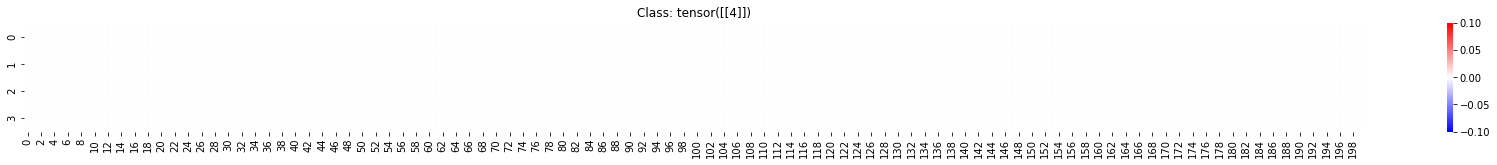

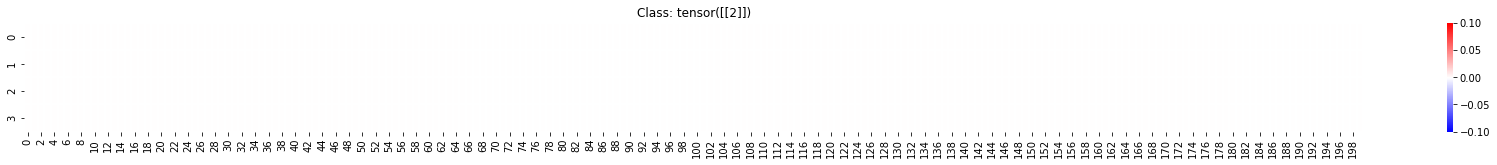

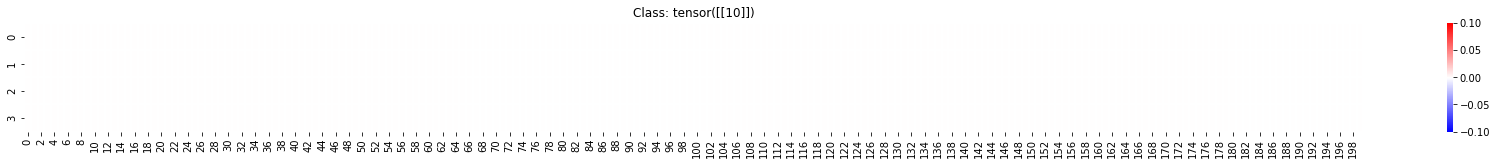

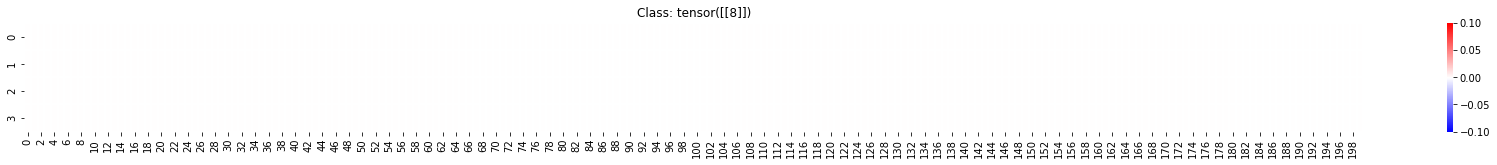

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

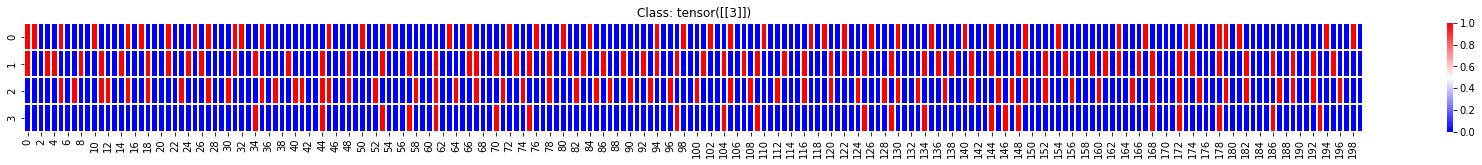

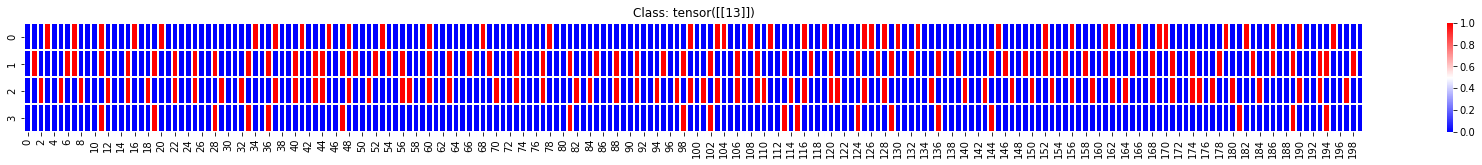

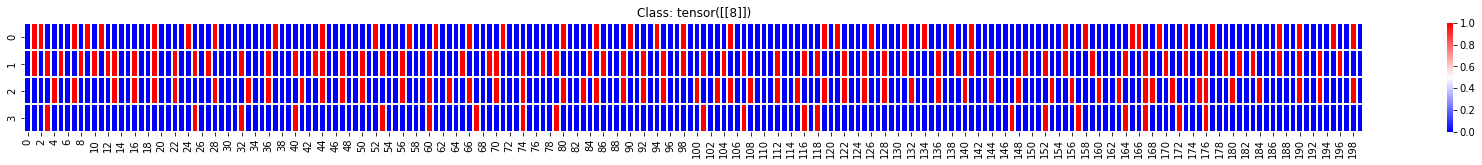

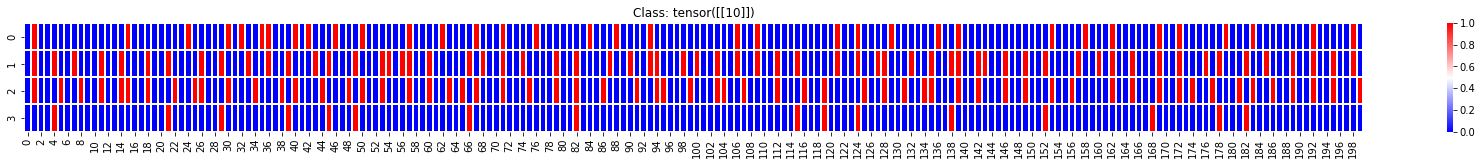

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

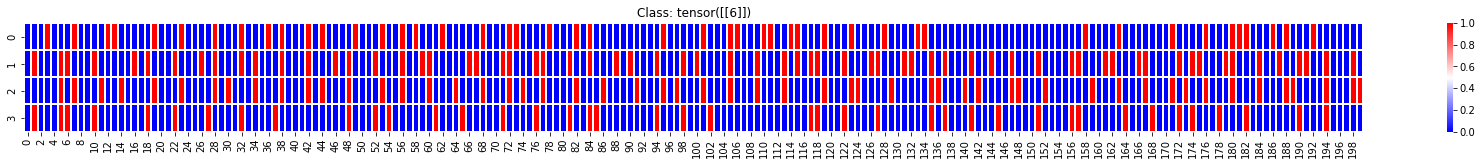

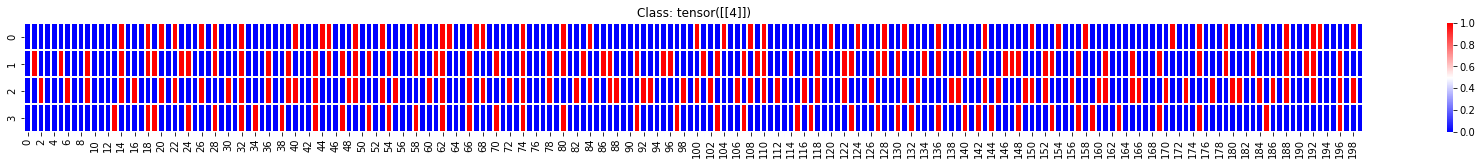

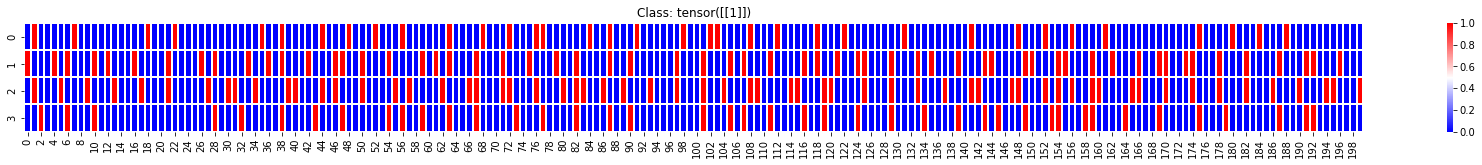

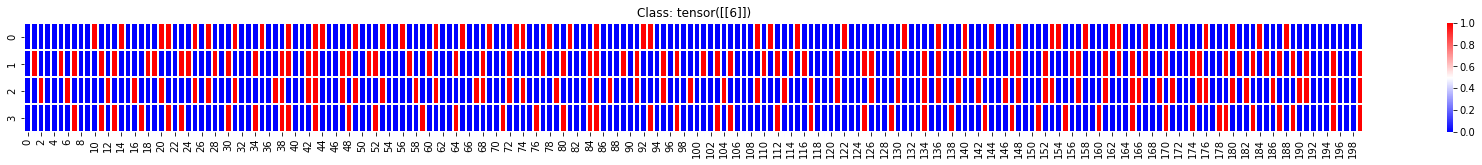

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

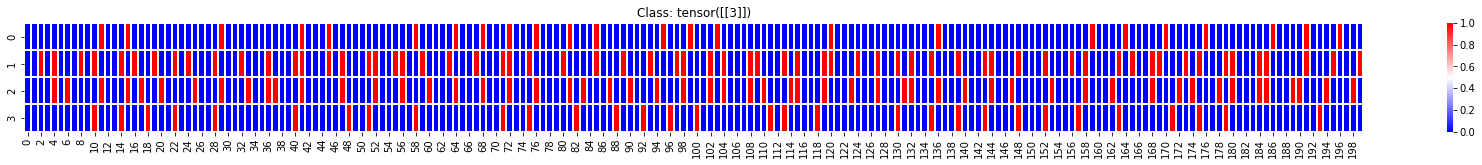

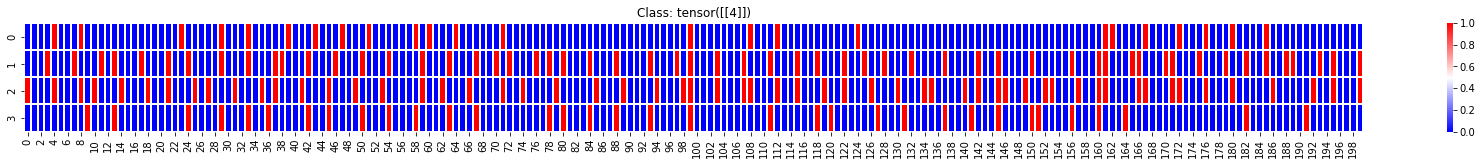

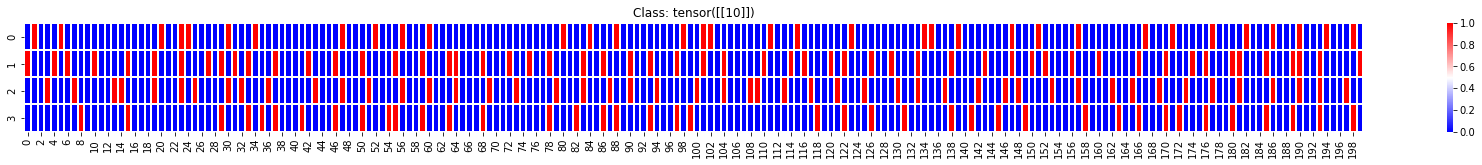

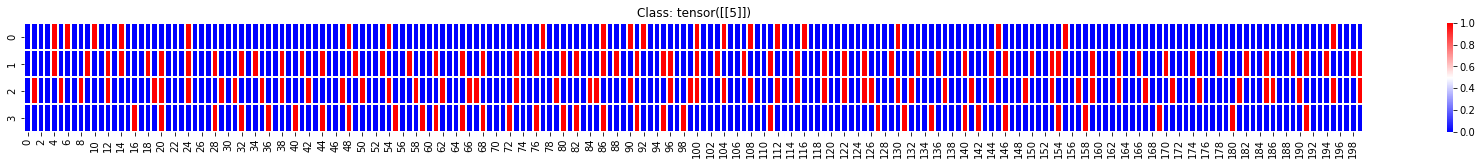

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

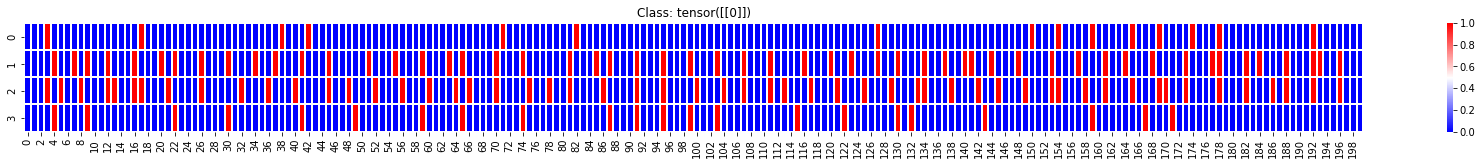

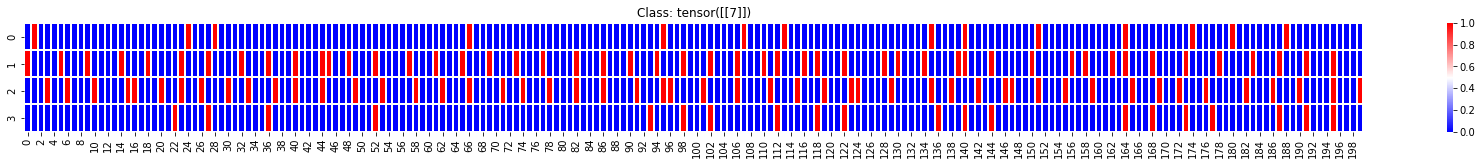

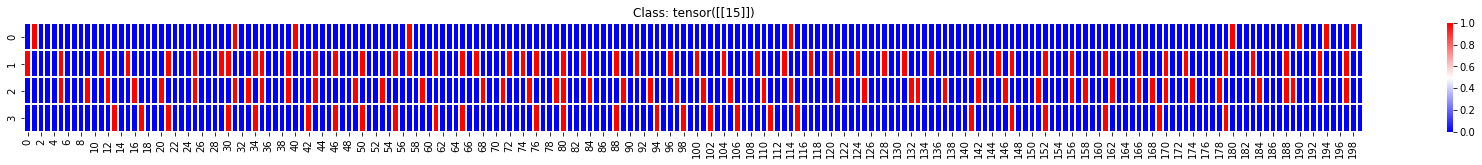

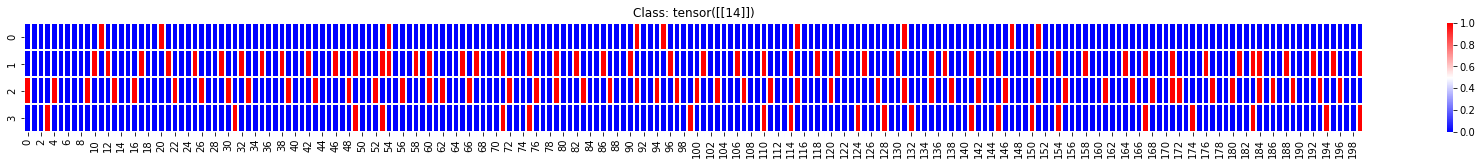

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

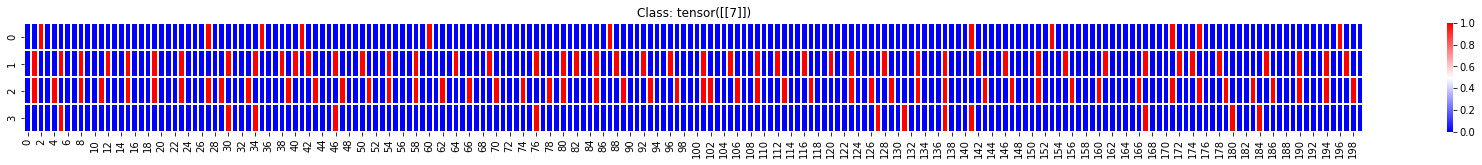

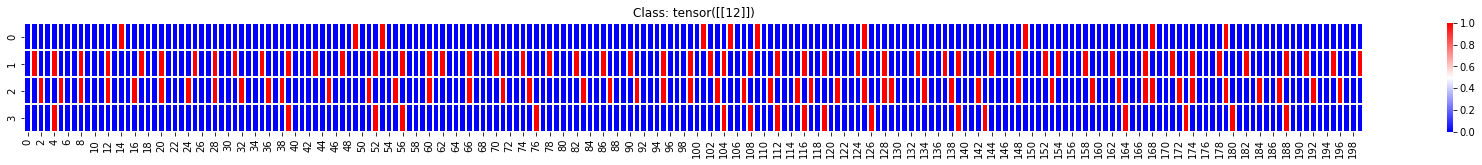

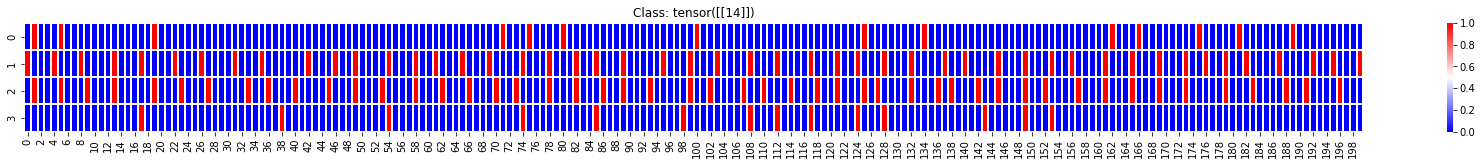

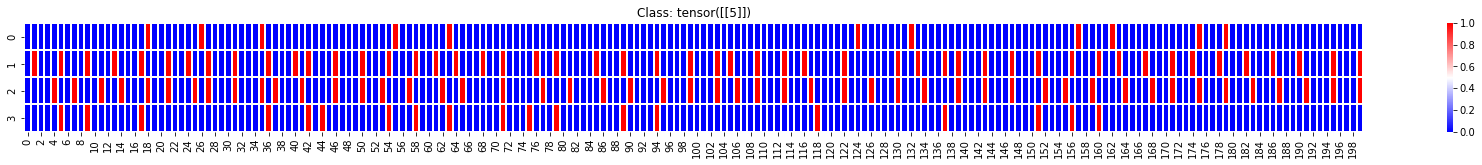

KeyboardInterrupt: ignored

In [80]:

# Training is stable when I accumulate gradients 
# The memory requirement is huge the batch can't be too big

torch.cuda.empty_cache()
gc.collect()


SHOW_PROGRESS_INTERVAL = 25
NUM_EPOCHS = 1000
outer = tqdm(total=NUM_EPOCHS, desc='Epochs', position=1)
inner = tqdm(total=len(train_dl), desc='Loss', position=0)
for t in range(1000):
  total_loss = 0
  for step, batch in tqdm(enumerate(train_dl), desc=f"epoch {t}", total=len(train_dl)):
    optimizer.zero_grad()
    images, classes = batch
    images = images.cuda()
    classes = classes.float().cuda()

    loss = bit_diffusion(images, classes)
    total_loss += loss.cpu().item()
    loss.backward()
    # after a lot of training
    inner.set_description_str(f"Loss: {total_loss/(step+1)}")
    optimizer.step()
    optimizer.zero_grad()

    if (step % SHOW_PROGRESS_INTERVAL ) == 0:
      sample_bs = 4 
      sampled = torch.from_numpy(np.random.randint(0, len(cell_types), size=(sample_bs)))
      random_classes = torch.zeros((sample_bs, len(cell_types)))
      random_classes = random_classes.scatter_(1, sampled.unsqueeze(dim=1), 1).float().cuda()

      sampled_images = bit_diffusion.sample(batch_size=sample_bs, classes=random_classes)
      random_classes = random_classes.cpu()
      sampled_images = sampled_images.cpu()
      for x, c in zip(sampled_images, random_classes):
        df = pd.DataFrame(x.squeeze().numpy())
        plt.rcParams["figure.figsize"] = (30,2)
        plt.title(f"Class: {c.nonzero()}")
        sns.heatmap(df, cmap='bwr', linewidths=1)
        plt.show() 

#Sampling from the learned model

In [ ]:
sampled_images = bit_diffusion.sample(batch_size = 4)
sampled_images = sampled_images.cpu()
for x in sampled_images:
  df = pd.DataFrame(x.reshape(4,200).numpy())
  plt.rcParams["figure.figsize"] = (30,2)
  sns.heatmap(df, cmap='bwr', linewidths=1)
  plt.show()

# Generating some images to secondary evaluations

In [ ]:

final_sequences=[]
for n_a in tqdm_notebook(range(25)): # generating 100 sequences
  sampled_images = bit_diffusion.sample(batch_size = 4)
  sampled_images = sampled_images.cpu()
  for n_b, x in enumerate(sampled_images):
    seq_final = f'>seq_test_{n_a}_{n_b}\n' +''.join([nucleotides[s] for s in np.argmax(x.reshape(4,200), axis=0)]) 
    final_sequences.append(seq_final)



save_motifs_syn = open('synthetic_motifs.fasta', 'w')

save_motifs_syn.write('\n'.join(final_sequences))
save_motifs_syn.close()
!gimme scan synthetic_motifs.fasta -p  JASPAR2018_vertebrates -g hg19 > syn_results_motifs.bed
df_results_syn = pd.read_csv('syn_results_motifs.bed', sep='\t', skiprows=5, header=None)
df_results_syn['motifs'] = df_results_syn[8].apply(lambda x: x.split( 'motif_name "'    )[1].split('"')[0]   )
df_motifs_count_syn = df_results_syn.groupby('motifs').count()
plt.rcParams["figure.figsize"] = (30,2)
df_motifs_count_syn.sort_values(0, ascending=False).head(50)[0].plot.bar()


scanning: 100% 172/172 [00:03<00:00, 50.72 sequences/s]


EmptyDataError: ignored

In [ ]:
#!cp synthetic_motifs_haystack.fasta /content/drive/MyDrive